# Case Study: Fraud Detection

## Goals of this notebook:
- Data visualization
- Dealing with imbalanced data --> synthetic minority oversampling technique (SMOTE)
- Dimensionality reduction
- Run Scikit-learn Baseline methods
- Run Tensorflow


Ref: https://www.kaggle.com/mlg-ulb/creditcardfraud

## Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Content

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Inspiration

Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Acknowledgements

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

## Library

In [1]:
import time
import scipy.stats as stats
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import StandardScaler # to normalize feats
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [2]:
import numpy as np

# Define my metrics
def ji_get_metrics(C):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    
    Good reading: http://stats.stackexchange.com/questions/49579/balanced-accuracy-vs-f-1-score
    
    """
    
    allres = matlab_like()
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1]
    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN
    TPR = tp / (NP+0.) # Sensitivity or Recall_P
    TNR = tn / (NN+0.) # Specificity or Recall_N
    
    print('TN=%d, FP=%d'%(tn,fp))
    print('FN=%d, TP=%d'%(fn,tp))
        
    
    precision = (tp/(tp+fp+0.)) # Precision_P
    recall = TPR
    
    allres.C0 = TNR
    allres.C1 = TPR
    allres.Precision = precision
    allres.Recall = recall
    allres.BAcc = (TPR+TNR)/2 
    allres.F1 = 2*((precision*recall)/(precision+recall))
    
    return allres

In [3]:
# Function to plot Confusion Matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# Class to create Matlab-like structure
class matlab_like():
    pass

## Load the data set

In [5]:
# 1) Import data
df = pd.read_csv("0_data/creditcard.csv")
df.head() # notice that the features are anonymized

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# If you want to alter/categorize or fix a particular categorical variable (not the case here...)
def val_update(val):
    if val<0:
        return 0
    else:
        return 1
#aux = df['V1'].apply(val_update)
#aux.head()

In [7]:
# Check if there are missing values 
# --> NO!
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Data Exploration

Inherited from: https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow

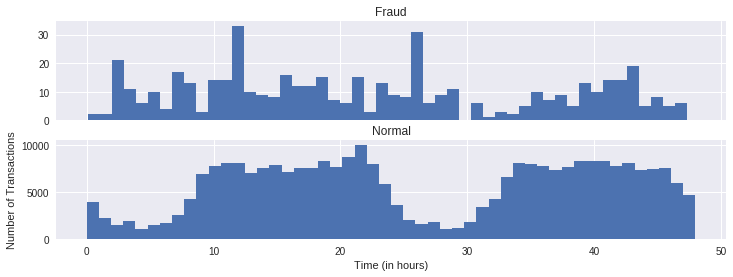

In [8]:
# 1) Examining if there is any temporal paterns in terms of fraud (1) or normal (0)
# --> Interestingly, there is a peak of occurence at "night" when normal transaction are off-peak?
# --> Time might be a useless feature since we only have 2 cycles (days)...
import matplotlib.pyplot as plt
% matplotlib inline
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
bins = 50
ax1.hist(df.Time[df.Class == 1]/(60*60), bins = bins)
ax1.set_title('Fraud')
ax2.hist(df.Time[df.Class == 0]/(60*60), bins = bins)
ax2.set_title('Normal')
plt.xlabel('Time (in hours)')
plt.ylabel('Number of Transactions')
plt.show()

In [9]:
# 2) Any patterns in terms of the Amount of the transaction?
# --> Clearly, amount is an important feature!
print ("Fraud")
print (df.Amount[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Amount[df.Class == 0].describe())
print ()
t, p = stats.ttest_ind(df.Amount[df.Class == 1],df.Amount[df.Class == 0])
print ('2 sample t-test:p=%2.4f, t=%2.2f'%(p,t))

Fraud
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

2 sample t-test:p=0.0027, t=3.01


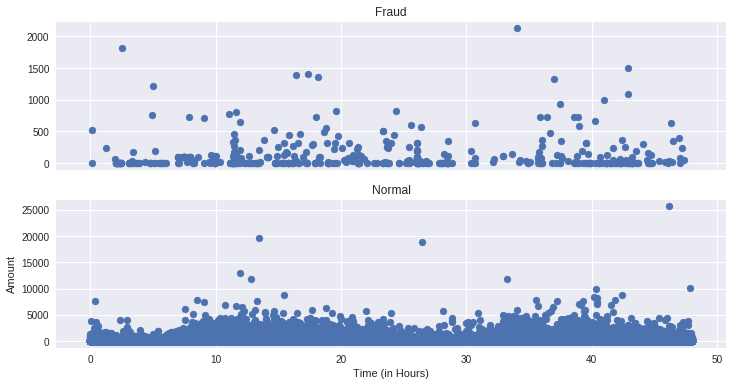

In [10]:
# 3) What about the Amount across the Time?
# --> No clear pattern
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax1.scatter(df.Time[df.Class == 1]/3600, df.Amount[df.Class == 1])
ax1.set_title('Fraud')

ax2.scatter(df.Time[df.Class == 0]/3600, df.Amount[df.Class == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Hours)')
plt.ylabel('Amount')
plt.show()

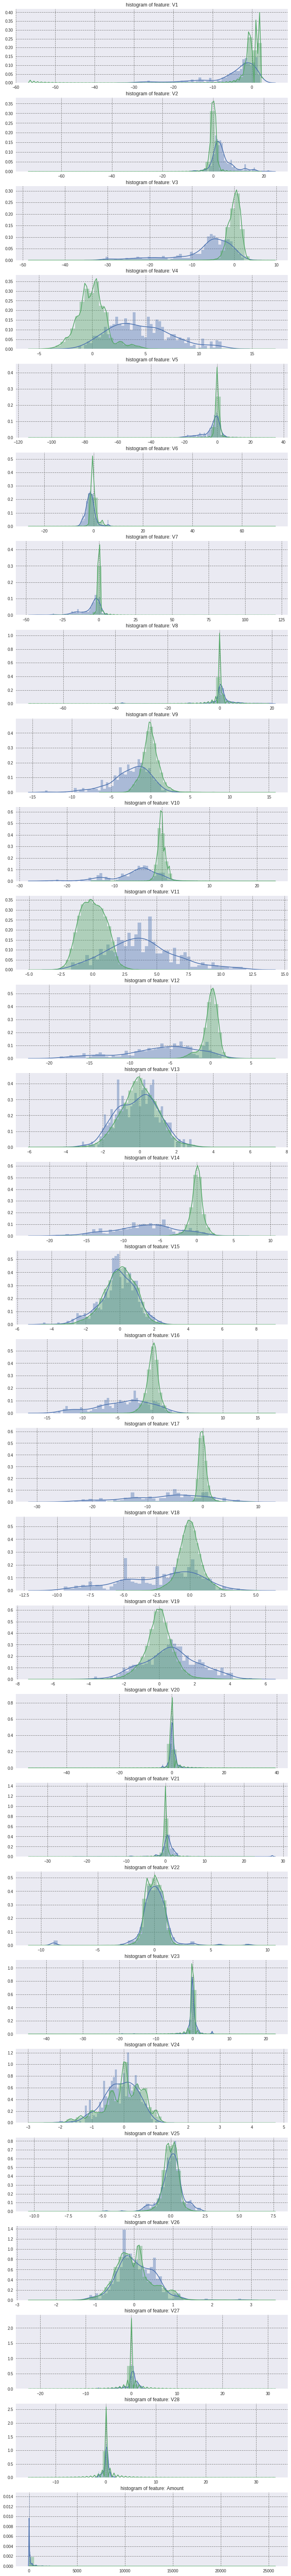

In [11]:
# 4) Examining the distribution of the features (exclude Time)
# --> Some feats look useless
list_features = df.iloc[:,1:30].columns
plt.figure(figsize=(12,29*4))
gs = gridspec.GridSpec(29, 1)
for i, cn in enumerate(df[list_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
    # grid
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed')
plt.show()

In [50]:
# Original data to keep:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Feature Engineering

Ref: 

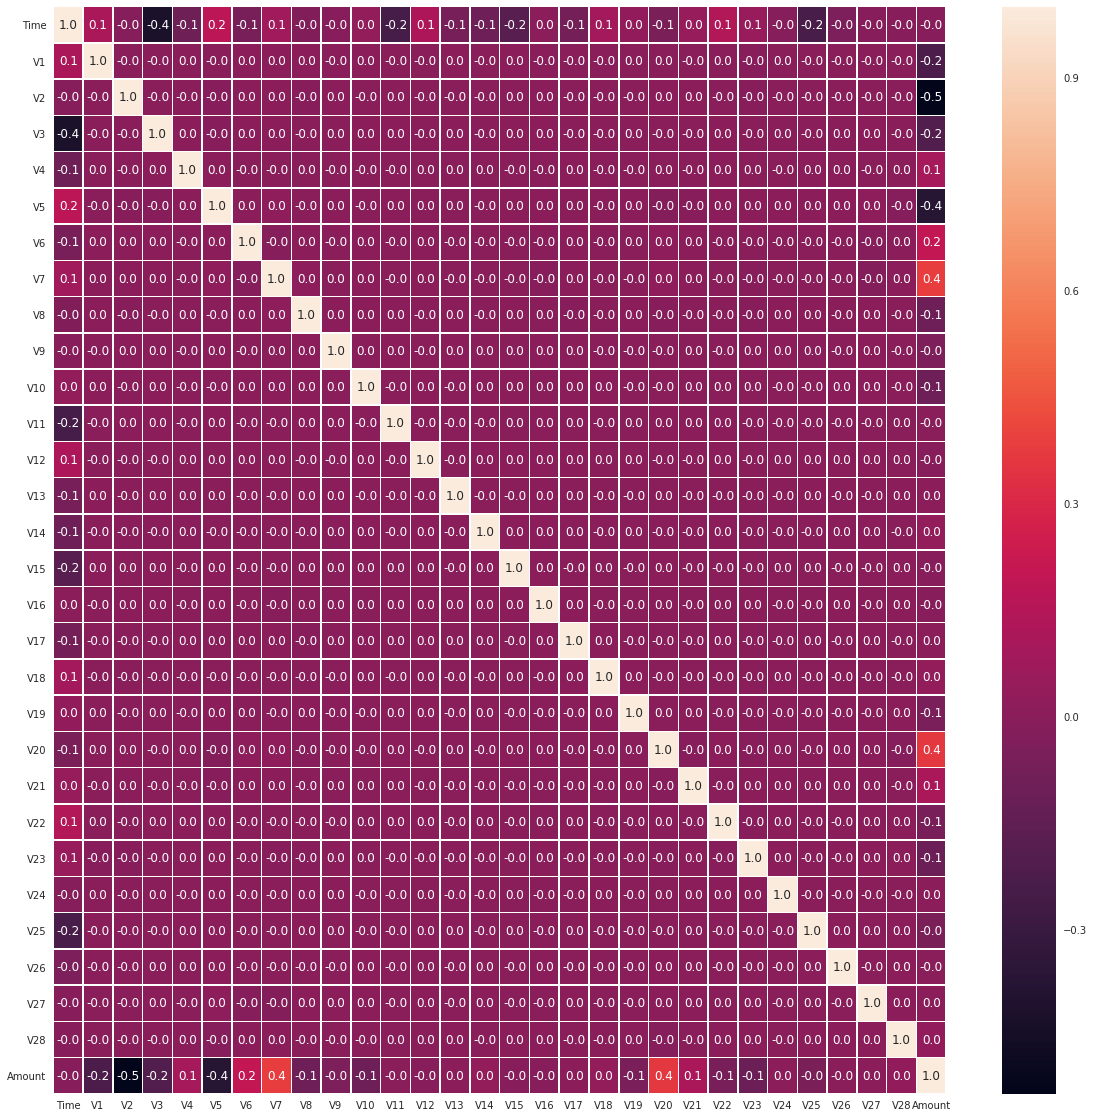

In [105]:
# 1) Check correlation among feats 
# --> you can consider removing correlated feats, since it creates colinearity in regression-based approaches

# Cross-correlation map of the features
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
#sns.heatmap(xx.iloc[126:146,245:265], annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [115]:
# 2) Univariate Approaches: KBest and Chi2
from sklearn.feature_selection import SelectKBest,chi2,f_classif,mutual_info_classif

# Some options: f_classif (ANOVA), chi2, mutual_info_classif
# find k-best scored 10 features
select_feature1 = SelectKBest(f_classif, k=10).fit(X_train, y_train)
print(X_train.columns[select_feature1.get_support()])
select_feature2 = SelectKBest(chi2, k=10).fit(X_train.abs(), y_train)
print(X_train.columns[select_feature2.get_support()])
#select_feature3 = SelectKBest(mutual_info_classif, k=10).fit(X_train, y_train)
#print(X_train.columns[select_feature3.get_support()])

# Transform data
X_train_UnivariateF = select_feature1.transform(X_train)
X_test_UnivariateF = select_feature1.transform(X_test)

Index([u'V3', u'V4', u'V7', u'V10', u'V11', u'V12', u'V14', u'V16', u'V17',
       u'V18'],
      dtype='object')
Index([u'Time', u'V3', u'V7', u'V8', u'V10', u'V12', u'V14', u'V16', u'V17',
       u'Amount'],
      dtype='object')


In [ ]:
# 3) Recursive feature elimination (RFE) using Random Forest¶ (could be any other...)
# - http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html 
# - Basically, it uses one of the classification methods (random forest in our example), 
# assign weights to each of features. Whose absolute weights are the smallest are pruned 
# from the current set features. That procedure is recursively repeated on the pruned set until 
# the desired number of features
tic = time.time()

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier # Random forest classifier

# Here, we will apply RFE on the undersampled data so that it will not be affected by the data imbalance

# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier(n_estimators=10)      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=15, step=1)
# Normalize
XX_train = X_undersampled.copy()
yy_train = y_undersampled.copy()
cols_to_norm = ['Time','Amount']
#XX_train[cols_to_norm] = XX_train[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())
XX_train[cols_to_norm] = XX_train[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

rfe = rfe.fit(XX_train, yy_train)
print('Chosen best 15 features by Recursive Feature Elimination:',XX_train.columns[rfe.support_])

X_train_RFE = rfe.transform(X_train)
X_test_RFE = rfe.transform(X_test)

toc = time.time()
print("Computation time: %d seconds"%(toc-tic))

In [72]:
# 4) t-SNE (good for visualization)
# - t-Distributed Stochastic Neighbor Embedding (t-SNE) is a (prize-winning) technique for dimensionality reduction
# that is particularly well suited for the visualization of high-dimensional datasets. The technique can be 
# implemented via Barnes-Hut approximations, allowing it to be applied on large real-world datasets. 
# - t-distributed Stochastic Neighbor Embedding. t-SNE [1] is a tool to visualize high-dimensional data. 
# It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler 
# divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.
# t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.
# - It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or 
# TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) 
# if the number of features is very high. This will suppress some noise and speed up the computation of 
# pairwise distances between samples. For more tips see Laurens van der Maaten’s FAQ [2].
# - Ref: - https://lvdmaaten.github.io/tsne/
#        - http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import time
import pandas as pd
import numpy as np

# Select the dataset to transform
XX_train = X_undersampled.copy()
yy_train = y_undersampled.copy()

#Scale features to improve the training ability of TSNE.
standard_scaler = StandardScaler()
XX_train_std = standard_scaler.fit_transform(XX_train)
XX_train_std.shape

(696, 30)

In [73]:
# Compute t-SNE
tic = time.time()
tsne = TSNE(n_components=2, random_state=101)
XX_train_2d = tsne.fit_transform(XX_train_std)
toc = time.time()
print("Computation time: %d seconds"%(toc-tic))

Computation time: 20 seconds


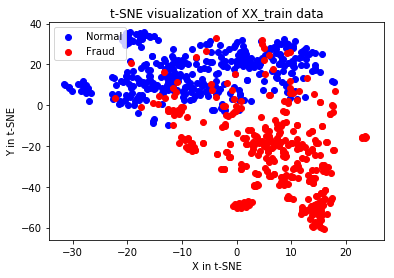

In [74]:
#Build the scatter plot with the two types of transactions.
color_map = {0:'red', 1:'blue'}
plt.figure()
yy = yy_train.Class.values
allX = XX_train_2d[:,0]
allY = XX_train_2d[:,1]
plt.scatter(x = allX[yy==0], y = allY[yy==0], c = 'blue', label = 'Normal')
plt.scatter(x = allX[yy==1], y = allY[yy==1], c = 'red', label = 'Fraud')
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of XX_train data')
plt.show()

## Prepare training & validation & testing

In [11]:
# ORIGINAL DATA
# - df
# - x_data
# - y_labels

# 2) Prepare the learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

x_data = df.drop('Class',axis=1)
y_labels = df['Class']
y_names = ['Normal','Fraud']

X_train, X_test, y_train, y_test = train_test_split(x_data,y_labels,test_size=0.3,random_state=101)
print('Train+Validation:%s, Test:%s'%(X_train.shape,X_test.shape))

# 2.a) Random Cross Validation (10-folds)
k_3folds = KFold(n_splits=3,random_state=101)
k_5folds = KFold(n_splits=5,random_state=101)
k_10folds = KFold(n_splits=10,random_state=101)
for train_indices, validation_indices in k_5folds.split(X_train):
     print('Index,Train: %s|Valid: %s' % (train_indices, validation_indices))

# 2.b) Stratified Cross Validation (10-folds) - distributed based on labels
sk_3folds = StratifiedKFold(n_splits=3, random_state=101)
sk_5folds = StratifiedKFold(n_splits=5, random_state=101)
sk_10folds = StratifiedKFold(n_splits=10, random_state=101)

# Showing ratio
dfaux = y_train
print("")
print("** Train+Validation Data **")
print("Percentage of normal transactions: %1.4f (n=%d)"%(len(dfaux[dfaux == 0])/float(len(dfaux)),len(dfaux[dfaux == 0])))
print("Percentage of fraud transactions: %1.4f (n=%d)"%(len(dfaux[dfaux == 1])/float(len(dfaux)),len(dfaux[dfaux == 1])))
print("Total number of transactions in resampled data: %d"%(len(dfaux)))
# Showing ratio
dfaux = y_test
print("")
print("** Test Data **")
print("Percentage of normal transactions: %1.4f (n=%d)"%(len(dfaux[dfaux == 0])/float(len(dfaux)),len(dfaux[dfaux == 0])))
print("Percentage of fraud transactions: %1.4f (n=%d)"%(len(dfaux[dfaux == 1])/float(len(dfaux)),len(dfaux[dfaux == 1])))
print("Total number of transactions in resampled data: %d"%(len(dfaux)))

Train+Validation:(199364, 30), Test:(85443, 30)
Index,Train: [ 39873  39874  39875 ... 199361 199362 199363]|Valid: [    0     1     2 ... 39870 39871 39872]
Index,Train: [     0      1      2 ... 199361 199362 199363]|Valid: [39873 39874 39875 ... 79743 79744 79745]
Index,Train: [     0      1      2 ... 199361 199362 199363]|Valid: [ 79746  79747  79748 ... 119616 119617 119618]
Index,Train: [     0      1      2 ... 199361 199362 199363]|Valid: [119619 119620 119621 ... 159489 159490 159491]
Index,Train: [     0      1      2 ... 159489 159490 159491]|Valid: [159492 159493 159494 ... 199361 199362 199363]

** Train+Validation Data **
Percentage of normal transactions: 0.9983 (n=199016)
Percentage of fraud transactions: 0.0017 (n=348)
Total number of transactions in resampled data: 199364

** Test Data **
Percentage of normal transactions: 0.9983 (n=85299)
Percentage of fraud transactions: 0.0017 (n=144)
Total number of transactions in resampled data: 85443


## Dealing with Imbalanced Data: Sampling Approach

**OBS**: Here, we have to be careful to not use the test for the sampling purpose... otherwise, we will already use the class information. Thus, the correct thing to do is a Sampling on the training data solely, leaving the test data completely apart

### 1) Undersampling: create dataset with proportional train/test

**Obs** We set the proportion to Normal/Fraud: 50%/50%. Changing it, would change Precision/Recall... In other experiments, it is possible to see that increasing the proportion of Normal, we have better Precision, but worst Recall.

In [13]:
# Set data to undersample. The example used the whole data, but maybe this is not correct...
#datax = pd.concat([x_data,y_labels],axis=1) # This would use the whole data including Test... (maybe it is OK)
datax0 = pd.concat([x_data,y_labels],axis=1) # ORIGINAL DATA
datax = pd.concat([X_train,y_train],axis=1) #

# Number of data points in the minority class
number_records_fraud = len(datax[datax.Class == 1])
fraud_indices = np.array(datax[datax.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = datax[datax.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sampled_data = datax0.iloc[under_sample_indices,:]
under_sampled_data_shuffled = under_sampled_data.sample(frac=1) # shuffle data to use for train/test

X_undersampled = under_sampled_data_shuffled.loc[:, under_sampled_data_shuffled.columns != 'Class'] # Do not use direct to train/test...
y_undersampled = under_sampled_data_shuffled.loc[:, under_sampled_data_shuffled.columns == 'Class']

# Showing ratio
aux0 = len(under_sampled_data[under_sampled_data.Class == 0])
aux1 = len(under_sampled_data[under_sampled_data.Class == 1])
print("Percentage of normal transactions: %1.2f (n=%d)"%(aux0/float(len(under_sampled_data)),aux0))
print("Percentage of fraud transactions: %1.2f (n=%d)"%(aux1/float(len(under_sampled_data)),aux1))
print("Total number of transactions in resampled data: %d"%(len(under_sampled_data)))


Percentage of normal transactions: 0.50 (n=348)
Percentage of fraud transactions: 0.50 (n=348)
Total number of transactions in resampled data: 696


In [14]:
# Split into Train and Validation data sets
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Undersampled dataset
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = \
               train_test_split(X_undersampled,y_undersampled,test_size = 0.3,random_state = 0)
print("")
print("Number transactions train dataset: ", len(X_train_undersampled))
print("Number transactions validation dataset: ", len(X_test_undersampled))
print("Total number of transactions: ", len(X_train_undersampled)+len(X_test_undersampled))


('Number transactions train dataset: ', 487)
('Number transactions validation dataset: ', 209)
('Total number of transactions: ', 696)


### 2) SMOTE: Synthetic Minority Oversampling

In [54]:
# SMOTE (Ide, ICPR 2016)
# Check: - ji_Example_Nice_ML_Framework.ipynb
#        - ji_example_SMOTE.ipynb

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# SMOTE and others..

# a) Standard SMOTE
sm = SMOTE(kind='regular')
X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train, y_train)
print('Applied SMOTE: y_train old_size=%d (#fraud=%d), new_size=%d (#fraud=%d)'%(len(y_train),len(y_train[y_train==1]),len(y_train_SMOTE),len(y_train_SMOTE[y_train_SMOTE==1])))
X_train_SMOTE = pd.DataFrame(X_train_SMOTE,columns=X_train.columns)
y_train_SMOTE = pd.Series(y_train_SMOTE)
# Shuffle data
iprm = np.random.permutation(len(y_train_SMOTE))
X_train_SMOTE = X_train_SMOTE.iloc[iprm]
y_train_SMOTE = y_train_SMOTE.iloc[iprm]

# b) Borderline SMOTE
sm = SMOTE(kind='borderline2',random_state=101) # better
X_train_SMOTE2, y_train_SMOTE2 = sm.fit_sample(X_train, y_train)
print('Applied SMOTE: y_train old_size=%d (#fraud=%d), new_size=%d (#fraud=%d)'%(len(y_train),len(y_train[y_train==1]),len(y_train_SMOTE2),len(y_train_SMOTE2[y_train_SMOTE2==1])))
X_train_SMOTE2 = pd.DataFrame(X_train_SMOTE2,columns=X_train.columns)
y_train_SMOTE2 = pd.Series(y_train_SMOTE2)
# Shuffle data
iprm = np.random.permutation(len(y_train_SMOTE2))
X_train_SMOTE2 = X_train_SMOTE2.iloc[iprm]
y_train_SMOTE2 = y_train_SMOTE2.iloc[iprm]

#sm = SMOTE(kind='svm')
# c) ADASYN
#sm = ADASYN()


Applied SMOTE: y_train old_size=199364 (#fraud=348), new_size=398032 (#fraud=199016)
Applied SMOTE: y_train old_size=199364 (#fraud=348), new_size=398032 (#fraud=199016)


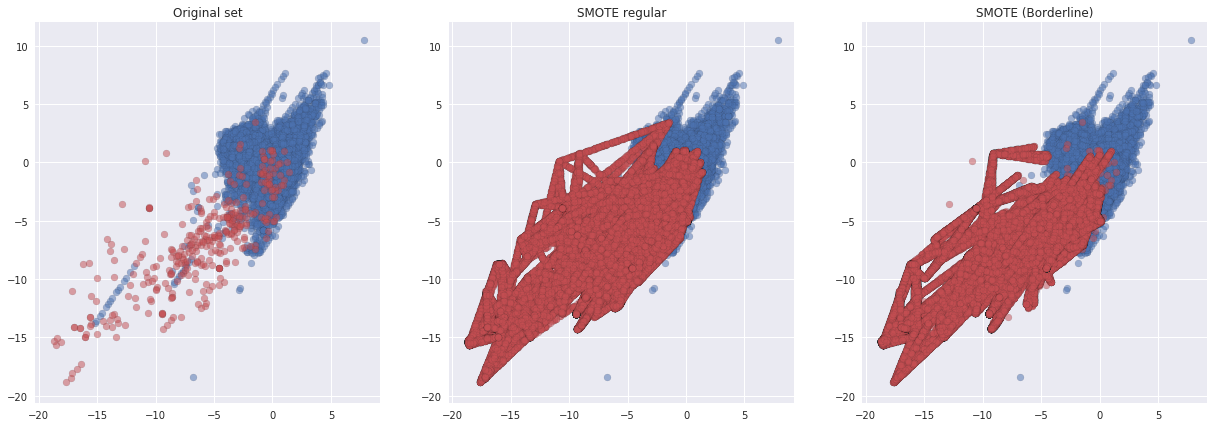

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 

# Select the pairs to represent!
#vv = ['V4','V11'] # good ones: V12, V11, V14
vv = ['V12','V14']
usePCA = False # PCA --> Not visually that interesting...

sns.set()
# Define some color for the plotting
almost_black = '#262626'
palette = sns.color_palette()

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)
# Fit and transform x to visualise inside a 2D feature space --> VISUALLY NOT INTERESTING...
if usePCA:
    X_vis = pca.fit_transform(X_train)
    X_res_vis = pca.transform(X_train_SMOTE)
    X_res_vis2 = pca.transform(X_train_SMOTE2)
else:
    X_vis = X_train[vv].values
    X_res_vis = X_train_SMOTE[vv].values
    X_res_vis2 = X_train_SMOTE2[vv].values

y = y_train.values
y_resampled = y_train_SMOTE.values
y_resampled2 = y_train_SMOTE2.values


# Two subplots, unpack the axes array immediately
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,7))

ax1.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], label="Class #0", alpha=0.5,
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
ax1.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], label="Class #1", alpha=0.5,
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_resampled == 0, 0], X_res_vis[y_resampled == 0, 1],
            label="Class #0", alpha=.5, edgecolor=almost_black,
            facecolor=palette[0], linewidth=0.15)
ax2.scatter(X_res_vis[y_resampled == 1, 0], X_res_vis[y_resampled == 1, 1],
            label="Class #1", alpha=.5, edgecolor=almost_black,
            facecolor=palette[2], linewidth=0.15)
ax2.set_title('SMOTE regular')

ax3.scatter(X_res_vis2[y_resampled2 == 0, 0], X_res_vis2[y_resampled2 == 0, 1],
            label="Class #0", alpha=.5, edgecolor=almost_black,
            facecolor=palette[0], linewidth=0.15)
ax3.scatter(X_res_vis2[y_resampled2 == 1, 0], X_res_vis2[y_resampled2 == 1, 1],
            label="Class #1", alpha=.5, edgecolor=almost_black,
            facecolor=palette[2], linewidth=0.15)
ax3.set_title('SMOTE (Borderline)')

plt.show()

###  3) Stratification approach: GNG + COM

Probably not relevant for this data which is not that small...

## Method 1: Baseline (from scikit-learn)

Metrics:
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN) = TPR
- Balanced Accuracy (BAcc): (TPR+TFR)/2

In [93]:
# Let's make a function so that we can test with different Train/Test data sets

def run_train_test_sklearn(XX_train,yy_train,XX_test,yy_test,set2use=0):
    # Import Classifiers from Scikitlearn
    from sklearn.linear_model import LogisticRegression
    from sklearn.neural_network import MLPClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC
    from sklearn.gaussian_process import GaussianProcessClassifier
    from sklearn.gaussian_process.kernels import RBF
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
    from sklearn.model_selection import KFold
    from sklearn.metrics import confusion_matrix
    from IPython.display import display
    
    # UPDATE IF NEEDED
    run_Strat = 0
    # 1) Choose baseline methods
    if set2use==0:
        names = ['Logistic']
        classifiers = [LogisticRegression(C = 0.1, penalty = 'l1')]
    if set2use==1:
        names = ['Logistic','RandomForest','AdaBoost']
        classifiers = [LogisticRegression(C = 0.1, penalty = 'l1'),
                       RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    if set2use==2:
        names = ["kNN5", "LinSVM","rbfSVM","DTree","RForest","AdaBoost","NBayes"]
        classifiers = [
            KNeighborsClassifier(5),
            SVC(kernel="linear", C=0.025),
            SVC(gamma=2, C=1),
            GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
            DecisionTreeClassifier(max_depth=5),
            RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
            AdaBoostClassifier(),
            GaussianNB()]
            #QuadraticDiscriminantAnalysis()]

    # DF to store results
    dfres = pd.DataFrame(columns=['Method','Precision(mean)','Precision(std)','Recall(mean)',\
                                  'Recall(std)','BAcc(mean)','BAcc(std)','Precision(Test data)','Recall(Test data)'])
    dfres['Method'] = names

    # Iterate over classifiers
    cont = 0
    all_confusion = []
    for name, clf in zip(names, classifiers):
        print('\n\n** Running Clf: %s...'%(name))
        # Have to split everytime
        if run_Strat == 1:
            kfx_aux = sk_5folds.split(XX_train,yy_train) # or sk_10folds use ".split(X_train,y_train)"
        else:
            kfx_aux = k_5folds.split(XX_train)

        ally_pred = []
        ally_true = []
        yscores = []
        folds_BAcc = []
        folds_Recall = []
        folds_Precision = []

        cont_fold = 0
        # 1) Cross-validation could be used to do ensemble or select model parameters
        for train_index, test_index in kfx_aux:
            X_trainx, X_testx = XX_train.iloc[train_index], XX_train.iloc[test_index]
            y_trainx, y_testx = yy_train.iloc[train_index], yy_train.iloc[test_index]
            # ACTUAL FITTING
            clf.fit(X_trainx, y_trainx)
            y_pred = clf.predict(X_testx)
            if hasattr(clf, "decision_function"):
                y_score = clf.fit(X_trainx,y_trainx).decision_function(X_testx)
                #Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else: # Use the prediction prob when score is not available
                y_score = clf.fit(X_trainx,y_trainx).predict_proba(X_testx)[:,1] 
                #Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            
            # Compute confusion matrix
            cnf_matrix = confusion_matrix(y_testx,y_pred)
            np.set_printoptions(precision=2)
            print("Recall metric in the Validation dataset#%d: %1.2f "%(cont_fold,cnf_matrix[1,1]/float(cnf_matrix[1,0]+cnf_matrix[1,1])))

            # Get scores
            res = ji_get_metrics(cnf_matrix)
            print("Precision: %1.2f"%(res.Precision))
            print("Recall(TPR): %1.2f"%(res.Recall))
            print("BAcc=(TPR+TNR)/2: %1.2f"%(res.BAcc))
            print("")
            
            # Store results
            folds_BAcc.append(res.BAcc)
            folds_Precision.append(res.Precision)
            folds_Recall.append(res.Recall)

            cont_fold += 1

            # Used for Summary Cofusion Matrix or ROC (TO DO...)
            ally_pred.extend(y_pred)
            ally_true.extend(y_test)
            yscores.extend(y_score)

        # Store results by Method (Cross-validation)
        dfres['Method'].iloc[cont] = name # just another way...
        dfres.loc[cont,'Precision(mean)'] = np.mean(folds_Precision)
        dfres.loc[cont,'Precision(std)'] = np.std(folds_Precision)
        dfres.loc[cont,'Recall(mean)'] = np.mean(folds_Recall)
        dfres.loc[cont,'Recall(std)'] = np.std(folds_Recall)
        dfres.loc[cont,'BAcc(mean)'] = np.mean(folds_BAcc)
        dfres.loc[cont,'BAcc(std)'] = np.std(folds_BAcc)

        # 2) Accuracy on the independent Test data
        clf.fit(XX_train, yy_train)
        y_pred = clf.predict(XX_test)
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(yy_test,y_pred)
        print("Recall metric in the Test dataset: %1.2f"%(cnf_matrix[1,1]/float(cnf_matrix[1,0]+cnf_matrix[1,1])))
        all_confusion.append(cnf_matrix)

        # Get scores
        res = ji_get_metrics(cnf_matrix)
        dfres.loc[cont,'Precision(Test data)'] = res.Precision
        dfres.loc[cont,'Recall(Test data)'] = res.Recall
        #dfres.loc[cont,'Recall(std)'] = np.std(folds_Recall)
        dfres.loc[cont,'BAcc(Test_data)'] = res.BAcc
        #dfres.loc[cont,'BAcc(std)'] = np.std(folds_BAcc)
        cont += 1


    # Plot non-normalized confusion matrix
    for name,cnf_matrix in zip(names,all_confusion):
        class_names = [0,1]
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, title= name+': Confusion matrix (Test data)')
        plt.show()
        #print("Recall metric in the Test dataset: %1.2f "%(cnf_matrix[1,1]/float(cnf_matrix[1,0]+cnf_matrix[1,1])))
    
    print('\n\nAverage performance on the Validation (cross-validated) and Test data')
    print('Obs: Precision:TP/(TP+FP) is very poor because the data is imbalanced and relativelly a large number of Normal transactions are classified as Fraud...')
    display(dfres)
    
    return dfres


## Results (sklearn basic models)
### Whole Skewed Data vs. Undersampled Data vs. SMOTE (oversampling)

### a) Training with Raw Imbalanced Data



** Running Clf: Logistic...
Recall metric in the Validation dataset#0: 0.62 
Precision: 0.88
Recall(TPR): 0.62
BAcc=(TPR+TNR)/2: 0.81

Recall metric in the Validation dataset#1: 0.55 
Precision: 0.89
Recall(TPR): 0.55
BAcc=(TPR+TNR)/2: 0.78

Recall metric in the Validation dataset#2: 0.65 
Precision: 0.85
Recall(TPR): 0.65
BAcc=(TPR+TNR)/2: 0.82

Recall metric in the Validation dataset#3: 0.53 
Precision: 0.79
Recall(TPR): 0.53
BAcc=(TPR+TNR)/2: 0.77

Recall metric in the Validation dataset#4: 0.61 
Precision: 0.90
Recall(TPR): 0.61
BAcc=(TPR+TNR)/2: 0.80

Recall metric in the Test dataset: 0.58


** Running Clf: RandomForest...
Recall metric in the Validation dataset#0: 0.46 
Precision: 0.90
Recall(TPR): 0.46
BAcc=(TPR+TNR)/2: 0.73

Recall metric in the Validation dataset#1: 0.31 
Precision: 0.92
Recall(TPR): 0.31
BAcc=(TPR+TNR)/2: 0.66

Recall metric in the Validation dataset#2: 0.63 
Precision: 0.91
Recall(TPR): 0.63
BAcc=(TPR+TNR)/2: 0.81

Recall metric in the Validation dataset#

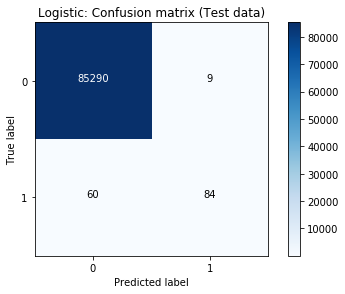

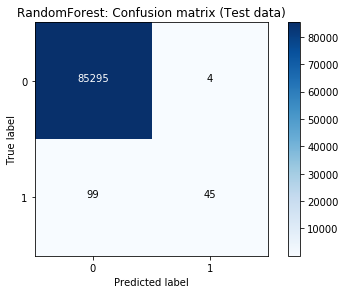

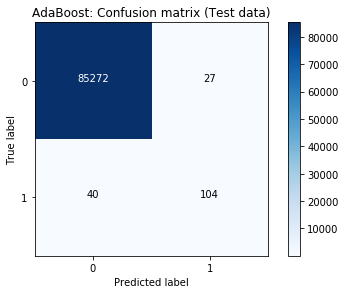



Average performance on the Validation (cross-validated) and Test data
Obs: Precision:TP/(TP+FP) is very poor because the data is imbalanced and relativelly a large number of Normal transactions are classified as Fraud...


,Method,Precision(mean),Precision(std),Recall(mean),Recall(std),BAcc(mean),BAcc(std),Precision(Test data),Recall(Test data),BAcc(Test_data)
0,Logistic,0.859783,0.0402169,0.591472,0.0419949,0.795653,0.0210017,0.903226,0.583333,0.791614
1,RandomForest,0.880395,0.0427831,0.461207,0.10798,0.730548,0.0539781,0.918367,0.3125,0.656227
2,AdaBoost,0.79501,0.0605716,0.734599,0.0314749,0.867131,0.0157553,0.793893,0.722222,0.860953


,Method,Precision(mean),Precision(std),Recall(mean),Recall(std),BAcc(mean),BAcc(std),Precision(Test data),Recall(Test data),BAcc(Test_data)
0,Logistic,0.859783,0.0402169,0.591472,0.0419949,0.795653,0.0210017,0.903226,0.583333,0.791614
1,RandomForest,0.880395,0.0427831,0.461207,0.10798,0.730548,0.0539781,0.918367,0.3125,0.656227
2,AdaBoost,0.79501,0.0605716,0.734599,0.0314749,0.867131,0.0157553,0.793893,0.722222,0.860953


In [91]:
XX_train = X_train 
yy_train = y_train
# Independent Test data
XX_test = X_test
yy_test = y_test
run_train_test_sklearn(XX_train,yy_train,XX_test,yy_test)


### b) Undersampled Data



** Running Clf: Logistic...
Recall metric in the Validation dataset#0: 0.98 
Precision: 0.97
Recall(TPR): 0.98
BAcc=(TPR+TNR)/2: 0.98

Recall metric in the Validation dataset#1: 0.89 
Precision: 0.98
Recall(TPR): 0.89
BAcc=(TPR+TNR)/2: 0.94

Recall metric in the Validation dataset#2: 0.85 
Precision: 0.98
Recall(TPR): 0.85
BAcc=(TPR+TNR)/2: 0.92

Recall metric in the Validation dataset#3: 0.95 
Precision: 0.95
Recall(TPR): 0.95
BAcc=(TPR+TNR)/2: 0.94

Recall metric in the Validation dataset#4: 0.90 
Precision: 0.93
Recall(TPR): 0.90
BAcc=(TPR+TNR)/2: 0.91

Recall metric in the Test dataset: 0.91


** Running Clf: RandomForest...


/home/jaime/anaconda3/envs/tfdeeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:80: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/jaime/anaconda3/envs/tfdeeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:86: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Recall metric in the Validation dataset#0: 0.94 
Precision: 0.97
Recall(TPR): 0.94
BAcc=(TPR+TNR)/2: 0.95

Recall metric in the Validation dataset#1: 0.82 
Precision: 1.00
Recall(TPR): 0.82
BAcc=(TPR+TNR)/2: 0.91

Recall metric in the Validation dataset#2: 0.81 
Precision: 0.97
Recall(TPR): 0.81
BAcc=(TPR+TNR)/2: 0.89

Recall metric in the Validation dataset#3: 0.85 
Precision: 0.98
Recall(TPR): 0.85
BAcc=(TPR+TNR)/2: 0.92

Recall metric in the Validation dataset#4: 0.87 
Precision: 0.98
Recall(TPR): 0.87
BAcc=(TPR+TNR)/2: 0.93

Recall metric in the Test dataset: 0.85


** Running Clf: AdaBoost...


/home/jaime/anaconda3/envs/tfdeeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Recall metric in the Validation dataset#0: 0.98 
Precision: 0.91
Recall(TPR): 0.98
BAcc=(TPR+TNR)/2: 0.95

Recall metric in the Validation dataset#1: 0.89 
Precision: 0.95
Recall(TPR): 0.89
BAcc=(TPR+TNR)/2: 0.92

Recall metric in the Validation dataset#2: 0.83 
Precision: 0.95
Recall(TPR): 0.83
BAcc=(TPR+TNR)/2: 0.89

Recall metric in the Validation dataset#3: 0.93 
Precision: 0.95
Recall(TPR): 0.93
BAcc=(TPR+TNR)/2: 0.94

Recall metric in the Validation dataset#4: 0.93 
Precision: 0.97
Recall(TPR): 0.93
BAcc=(TPR+TNR)/2: 0.95

Recall metric in the Test dataset: 0.92


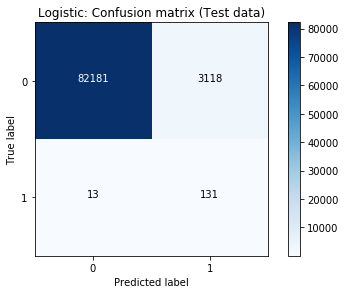

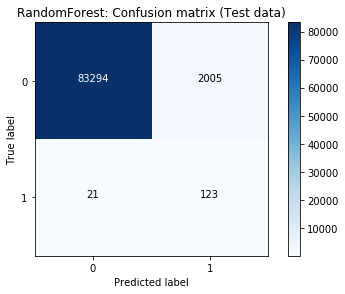

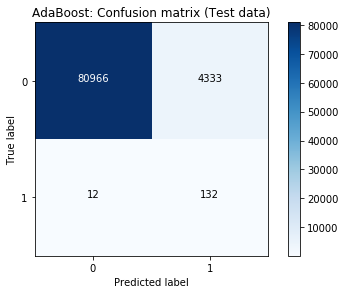



Average performance on the Validation (cross-validated) and Test data
Obs: Precision:TP/(TP+FP) is very poor because the data is imbalanced and relativelly a large number of Normal transactions are classified as Fraud...


,Method,Precision(mean),Precision(std),Recall(mean),Recall(std),BAcc(mean),BAcc(std),Precision(Test data),Recall(Test data),BAcc(Test_data)
0,Logistic,0.961564,0.0228753,0.912583,0.0475437,0.937467,0.0235979,0.0403201,0.909722,0.936584
1,RandomForest,0.980263,0.0125488,0.855771,0.0460356,0.91937,0.0221215,0.0578008,0.854167,0.915331
2,AdaBoost,0.946455,0.0196918,0.912899,0.0502347,0.930857,0.0214621,0.0295633,0.916667,0.932934


In [104]:
XX_train = X_undersampled # data was shuffled... (Train+Validation) data
yy_train = y_undersampled
# Independent Test data
XX_test = X_test
yy_test = y_test

set2use = 1 # 0: Logistic, 1: Logistic+RandomForest+AdaBoost, 3: complete...
dfres = run_train_test_sklearn(XX_train,yy_train,XX_test,yy_test,set2use)


### b.1) Undersampled Data + FeatSelection (Univariate ANOVA)



** Running Clf: Logistic...
Recall metric in the Validation dataset#0: 0.93 
TN=71, FP=0
FN=5, TP=64
Precision: 1.00
Recall(TPR): 0.93
BAcc=(TPR+TNR)/2: 0.96

Recall metric in the Validation dataset#1: 0.84 
TN=62, FP=2
FN=12, TP=63
Precision: 0.97
Recall(TPR): 0.84
BAcc=(TPR+TNR)/2: 0.90

Recall metric in the Validation dataset#2: 0.94 
TN=72, FP=3
FN=4, TP=60
Precision: 0.95
Recall(TPR): 0.94
BAcc=(TPR+TNR)/2: 0.95

Recall metric in the Validation dataset#3: 0.84 
TN=62, FP=0
FN=12, TP=65
Precision: 1.00
Recall(TPR): 0.84
BAcc=(TPR+TNR)/2: 0.92

Recall metric in the Validation dataset#4: 0.94 
TN=74, FP=2
FN=4, TP=59
Precision: 0.97
Recall(TPR): 0.94
BAcc=(TPR+TNR)/2: 0.96

Recall metric in the Test dataset: 0.89
TN=83847, FP=1452
FN=16, TP=128


** Running Clf: RandomForest...


/home/jaime/anaconda3/envs/tfdeeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/jaime/anaconda3/envs/tfdeeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Recall metric in the Validation dataset#0: 0.93 
TN=71, FP=0
FN=5, TP=64
Precision: 1.00
Recall(TPR): 0.93
BAcc=(TPR+TNR)/2: 0.96

Recall metric in the Validation dataset#1: 0.77 
TN=63, FP=1
FN=17, TP=58
Precision: 0.98
Recall(TPR): 0.77
BAcc=(TPR+TNR)/2: 0.88

Recall metric in the Validation dataset#2: 0.94 
TN=70, FP=5
FN=4, TP=60
Precision: 0.92
Recall(TPR): 0.94
BAcc=(TPR+TNR)/2: 0.94

Recall metric in the Validation dataset#3: 0.84 
TN=62, FP=0
FN=12, TP=65
Precision: 1.00
Recall(TPR): 0.84
BAcc=(TPR+TNR)/2: 0.92

Recall metric in the Validation dataset#4: 0.92 
TN=74, FP=2
FN=5, TP=58
Precision: 0.97
Recall(TPR): 0.92
BAcc=(TPR+TNR)/2: 0.95



/home/jaime/anaconda3/envs/tfdeeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:127: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Recall metric in the Test dataset: 0.87
TN=83235, FP=2064
FN=19, TP=125


** Running Clf: AdaBoost...
Recall metric in the Validation dataset#0: 0.94 
TN=71, FP=0
FN=4, TP=65
Precision: 1.00
Recall(TPR): 0.94
BAcc=(TPR+TNR)/2: 0.97

Recall metric in the Validation dataset#1: 0.88 
TN=60, FP=4
FN=9, TP=66
Precision: 0.94
Recall(TPR): 0.88
BAcc=(TPR+TNR)/2: 0.91

Recall metric in the Validation dataset#2: 0.97 
TN=66, FP=9
FN=2, TP=62
Precision: 0.87
Recall(TPR): 0.97
BAcc=(TPR+TNR)/2: 0.92

Recall metric in the Validation dataset#3: 0.87 
TN=62, FP=0
FN=10, TP=67
Precision: 1.00
Recall(TPR): 0.87
BAcc=(TPR+TNR)/2: 0.94

Recall metric in the Validation dataset#4: 0.92 
TN=69, FP=7
FN=5, TP=58
Precision: 0.89
Recall(TPR): 0.92
BAcc=(TPR+TNR)/2: 0.91

Recall metric in the Test dataset: 0.91
TN=80297, FP=5002
FN=13, TP=131


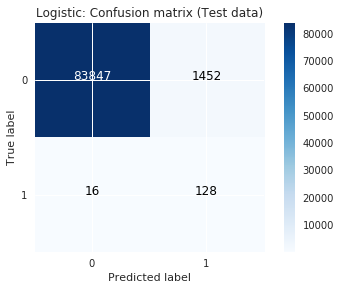

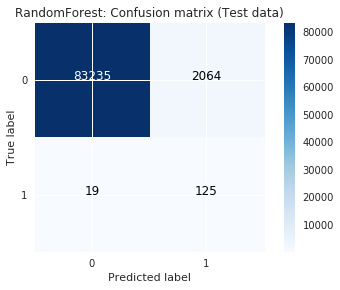

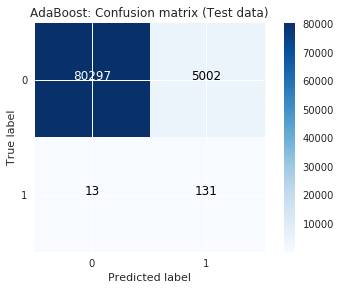



Average performance on the Validation (cross-validated) and Test data
Obs: Precision:TP/(TP+FP) is very poor because the data is imbalanced and relativelly a large number of Normal transactions are classified as Fraud...


,Method,Precision(mean),Precision(std),Recall(mean),Recall(std),BAcc(mean),BAcc(std),Precision(Test data),Recall(Test data),BAcc(Test_data)
0,Logistic,0.977765,0.0190647,0.89714,0.045111,0.938813,0.022148,0.0810127,0.888889,0.935933
1,RandomForest,0.974559,0.0285632,0.880632,0.0630519,0.929455,0.0287793,0.0571037,0.868056,0.921929
2,AdaBoost,0.941681,0.0527742,0.916309,0.0370976,0.930694,0.0220737,0.0255211,0.909722,0.925541


('Computation time: ', 3.0162458419799805, ' s')


In [125]:
tic = time.time()

# select_feature1: univariate selection with ANOVA: 20-Best
aux = select_feature1.transform(X_undersampled) # data was shuffled... (Train+Validation) data
XX_train = pd.DataFrame(aux,columns=X_undersampled.columns[select_feature1.get_support()])
yy_train = y_undersampled
# Independent Test data
XX_test = X_test_UnivariateF
yy_test = y_test

set2use = 1 # 0: Logistic, 1: Logistic+RandomForest+AdaBoost, 3: complete...
dfres_b1 = run_train_test_sklearn(XX_train,yy_train,XX_test,yy_test,set2use)

toc = time.time()
print("Computation time: ", toc-tic ," s")


### c) Training with SMOTE data (takes time...)



** Running Clf: Logistic...
Recall metric in the Validation dataset#0: 0.97 
TN=39578, FP=318
FN=1216, TP=38495
Precision: 0.99
Recall(TPR): 0.97
BAcc=(TPR+TNR)/2: 0.98

Recall metric in the Validation dataset#1: 0.97 
TN=39298, FP=317
FN=1205, TP=38787
Precision: 0.99
Recall(TPR): 0.97
BAcc=(TPR+TNR)/2: 0.98

Recall metric in the Validation dataset#2: 0.97 
TN=39442, FP=330
FN=1147, TP=38687
Precision: 0.99
Recall(TPR): 0.97
BAcc=(TPR+TNR)/2: 0.98

Recall metric in the Validation dataset#3: 0.97 
TN=39461, FP=310
FN=1175, TP=38660
Precision: 0.99
Recall(TPR): 0.97
BAcc=(TPR+TNR)/2: 0.98

Recall metric in the Validation dataset#4: 0.97 
TN=39639, FP=323
FN=1211, TP=38433
Precision: 0.99
Recall(TPR): 0.97
BAcc=(TPR+TNR)/2: 0.98

Recall metric in the Test dataset: 0.89
TN=84606, FP=693
FN=16, TP=128


** Running Clf: RandomForest...
Recall metric in the Validation dataset#0: 0.91 
TN=39698, FP=198
FN=3520, TP=36191
Precision: 0.99
Recall(TPR): 0.91
BAcc=(TPR+TNR)/2: 0.95

Recall metric

/home/jaime/anaconda3/envs/tfdeeplearning/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Recall metric in the Test dataset: 0.85
TN=85089, FP=210
FN=22, TP=122


** Running Clf: AdaBoost...
Recall metric in the Validation dataset#0: 0.98 
TN=39386, FP=510
FN=960, TP=38751
Precision: 0.99
Recall(TPR): 0.98
BAcc=(TPR+TNR)/2: 0.98

Recall metric in the Validation dataset#1: 0.98 
TN=39108, FP=507
FN=937, TP=39055
Precision: 0.99
Recall(TPR): 0.98
BAcc=(TPR+TNR)/2: 0.98

Recall metric in the Validation dataset#2: 0.98 
TN=39289, FP=483
FN=862, TP=38972
Precision: 0.99
Recall(TPR): 0.98
BAcc=(TPR+TNR)/2: 0.98

Recall metric in the Validation dataset#3: 0.98 
TN=39252, FP=519
FN=880, TP=38955
Precision: 0.99
Recall(TPR): 0.98
BAcc=(TPR+TNR)/2: 0.98

Recall metric in the Validation dataset#4: 0.98 
TN=39494, FP=468
FN=871, TP=38773
Precision: 0.99
Recall(TPR): 0.98
BAcc=(TPR+TNR)/2: 0.98

Recall metric in the Test dataset: 0.88
TN=84302, FP=997
FN=17, TP=127


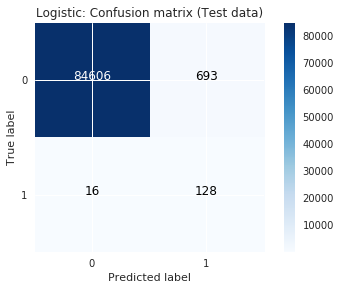

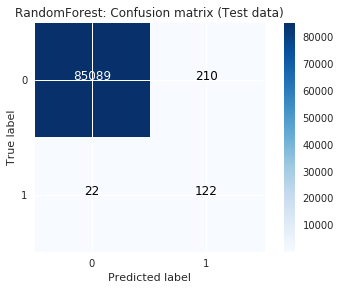

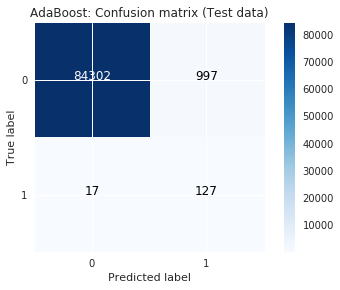



Average performance on the Validation (cross-validated) and Test data
Obs: Precision:TP/(TP+FP) is very poor because the data is imbalanced and relativelly a large number of Normal transactions are classified as Fraud...


,Method,Precision(mean),Precision(std),Recall(mean),Recall(std),BAcc(mean),BAcc(std),Precision(Test data),Recall(Test data),BAcc(Test_data)
0,Logistic,0.991791,0.000174894,0.970082,0.000689227,0.981026,0.000322318,0.155907,0.888889,0.940382
1,RandomForest,0.994503,0.00252282,0.897737,0.00815,0.946382,0.00381246,0.36747,0.847222,0.922380
2,AdaBoost,0.987376,0.000464303,0.977339,0.000972253,0.982421,0.000650074,0.112989,0.881944,0.935128


In [104]:
# REGULAR
XX_train = X_train_SMOTE
yy_train = y_train_SMOTE
# Independent Test data
XX_test = X_test
yy_test = y_test
set2use = 1 # 0: Logistic, 1: Logistic+RandomForest+AdaBoost, 3: complete...
dfres = run_train_test_sklearn(XX_train,yy_train,XX_test,yy_test,set2use)

In [127]:
dfres_c = dfres
display(dfres_c)

,Method,Precision(mean),Precision(std),Recall(mean),Recall(std),BAcc(mean),BAcc(std),Precision(Test data),Recall(Test data),BAcc(Test_data)
0,Logistic,0.991791,0.000174894,0.970082,0.000689227,0.981026,0.000322318,0.155907,0.888889,0.940382
1,RandomForest,0.994503,0.00252282,0.897737,0.00815,0.946382,0.00381246,0.36747,0.847222,0.922380
2,AdaBoost,0.987376,0.000464303,0.977339,0.000972253,0.982421,0.000650074,0.112989,0.881944,0.935128


### d) Training with SMOTE (borderline)



** Running Clf: Logistic...
Recall metric in the Validation dataset#0: 1.00 
TN=39564, FP=103
FN=190, TP=39750
Precision: 1.00
Recall(TPR): 1.00
BAcc=(TPR+TNR)/2: 1.00

Recall metric in the Validation dataset#1: 1.00 
TN=39625, FP=114
FN=185, TP=39683
Precision: 1.00
Recall(TPR): 1.00
BAcc=(TPR+TNR)/2: 1.00

Recall metric in the Validation dataset#2: 1.00 
TN=39799, FP=93
FN=190, TP=39524
Precision: 1.00
Recall(TPR): 1.00
BAcc=(TPR+TNR)/2: 1.00

Recall metric in the Validation dataset#3: 1.00 
TN=39652, FP=99
FN=180, TP=39675
Precision: 1.00
Recall(TPR): 1.00
BAcc=(TPR+TNR)/2: 1.00

Recall metric in the Validation dataset#4: 0.99 
TN=39876, FP=91
FN=204, TP=39435
Precision: 1.00
Recall(TPR): 0.99
BAcc=(TPR+TNR)/2: 1.00

Recall metric in the Test dataset: 0.85
TN=85085, FP=214
FN=21, TP=123


** Running Clf: RandomForest...
Recall metric in the Validation dataset#0: 0.98 
TN=39633, FP=34
FN=700, TP=39240
Precision: 1.00
Recall(TPR): 0.98
BAcc=(TPR+TNR)/2: 0.99

Recall metric in the Va

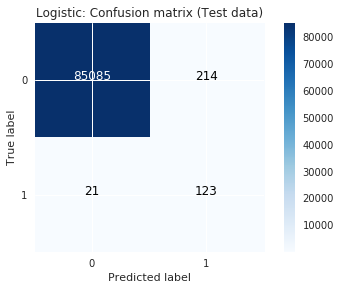

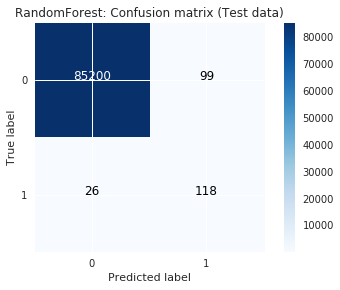

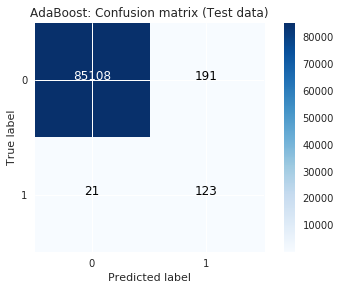



Average performance on the Validation (cross-validated) and Test data
Obs: Precision:TP/(TP+FP) is very poor because the data is imbalanced and relativelly a large number of Normal transactions are classified as Fraud...


,Method,Precision(mean),Precision(std),Recall(mean),Recall(std),BAcc(mean),BAcc(std),Precision(Test data),Recall(Test data),BAcc(Test_data)
0,Logistic,0.997482,0.000200479,0.995231,0.000211291,0.996359,9.48892e-05,0.364985,0.854167,0.925829
1,RandomForest,0.998428,0.00119524,0.976568,0.00515573,0.987516,0.00258386,0.543779,0.819444,0.909142
2,AdaBoost,0.997502,0.000297846,0.997518,0.000330572,0.997511,0.000243205,0.39172,0.854167,0.925964


('Computation time: ', 944.9931330680847, ' s')


In [128]:
# (Adaboost takes longer to run...)

tic = time.time()
# REGULAR
XX_train = X_train_SMOTE2
yy_train = y_train_SMOTE2
# Independent Test data
XX_test = X_test
yy_test = y_test
set2use = 1 # 0: Logistic, 1: Logistic+RandomForest+AdaBoost, 3: complete...
dfres_d = run_train_test_sklearn(XX_train,yy_train,XX_test,yy_test,set2use)
toc = time.time()
print("Computation time: ", toc-tic ," s")

## Method 2: Active Learning (To do...)

ji_HCP_ActiveLearning_Dmax_Apr18.ipynb

## Method 3: TensorFlow - DNN

### 1. Preparing data

In [17]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# 1) Define the data set to use
XX_train = X_undersampled # data was shuffled... (Train+Validation) data
yy_train = y_undersampled
# Independent Test data
XX_test = X_test
yy_test = y_test

# 2) Normalize colums (normalize Train and Test separately, more realistic...)
cols_to_norm = ['Amount']
XX_train[cols_to_norm] = XX_train[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
XX_test[cols_to_norm] = XX_test[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

### 2. Define Feature Columns

In [18]:
# 3.a) Define the columns (features) - categorical variable, if some
#gender = tf.feature_column.categorical_column_with_vocabulary_list("gender", ["Female", "Male"])
#education = tf.feature_column.categorical_column_with_hash_bucket("education", hash_bucket_size=1000)

# 3.b) Define the columns (features) - continuous variable, if some
feat_cols_tf = []
for i in XX_train.columns:
    feat_cols_tf.append(tf.feature_column.numeric_column(i))

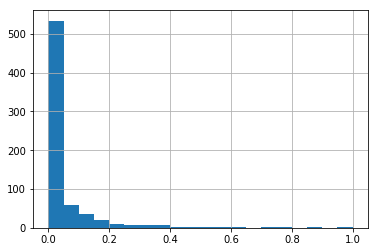

In [19]:
# 3.c) Discretize, if wanted... (buckets)
XX_train['Amount'].hist(bins=20)
Amount_buckets = tf.feature_column.bucketized_column(feat_cols_tf[-1], boundaries=[0.05,0.1,0.2,0.5,0.8])

In [20]:
# 4) Combine all the features --> make a list
#feat_cols_tf.append (Amount_buckets) (TEST LATER...)
feat_cols = feat_cols_tf

### 3. Define Inputs

In [21]:
input_func = tf.estimator.inputs.pandas_input_fn(x=XX_train,y=yy_train,batch_size=10,num_epochs=1000,shuffle=True)

In [22]:
XX_train.shape

(696, 30)

### 4. Train and Test LinearClassifier (Logist Regression) Model 

In [216]:
# Train
model = tf.estimator.LinearClassifier(feature_columns=feat_cols,n_classes=2,
optimizer=tf.train.FtrlOptimizer(learning_rate=0.1,l1_regularization_strength=1.0,l2_regularization_strength=0.0))
model.train(input_fn=input_func,steps=10000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1ca7dee5d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmp2fJFmG', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp2fJFmG/model.ckpt.
INFO:tensorflow:loss = 6.931472, step = 1
INFO:tensorflow:g

In [290]:
# Evaluate
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=XX_train,y=yy_train,batch_size=10,num_epochs=1,shuffle=False)
results = model.evaluate(eval_input_func)
results['accuracy']

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-25-03:59:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp2fJFmG/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-25-03:59:18
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.9353448, accuracy_baseline = 0.5, auc = 0.9516985, auc_precision_recall = 0.9649483, average_loss = 0.8583688, global_step = 10000, label/mean = 0.5, loss = 8.534638, prediction/mean = 0.49999598


0.9353448

In [218]:
# Test
pred_input_func = tf.estimator.inputs.pandas_input_fn(x=XX_test,batch_size=10,num_epochs=1,shuffle=False)
predictions = model.predict(pred_input_func)
y_pred = []
for pred in predictions:
    y_pred.append(pred['class_ids'][0])

# Compute confusion matrix (Test)
cnf_matrix = confusion_matrix(yy_test,y_pred)
print("Recall metric in the Test dataset: %1.2f"%(cnf_matrix[1,1]/float(cnf_matrix[1,0]+cnf_matrix[1,1])))
## Get scores
res = ji_get_metrics(cnf_matrix)
print("Precision: %1.2f"%(res.Precision))
print("Recall(TPR): %1.2f"%(res.Recall))
print("BAcc=(TPR+TNR)/2: %1.2f"%(res.BAcc))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp2fJFmG/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Recall metric in the Test dataset: 0.92
TN=79095, FP=6204
FN=12, TP=132
Precision: 0.02
Recall(TPR): 0.92
BAcc=(TPR+TNR)/2: 0.92


### 5. Train and Test DNN

In [23]:
# 1. Define the model
dnn_model = tf.estimator.DNNClassifier(hidden_units=[10,10,10],feature_columns=feat_cols,n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7618e0ce50>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpOZYnMC', '_save_summary_steps': 100}


In [220]:
# 2. If you have categorical varibles manually defined, you would have to do embedding...
#embedded_categorical_column = tf.feature_column.embedding_column(categorical_column, dimension=4)

In [310]:
# 3. Train
dnn_model.train(input_fn=input_func,steps=10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp39VQeF/model.ckpt.
INFO:tensorflow:loss = 72597.99, step = 1
INFO:tensorflow:global_step/sec: 160.041
INFO:tensorflow:loss = 9.212629, step = 101 (0.631 sec)
INFO:tensorflow:global_step/sec: 190.021
INFO:tensorflow:loss = 7.886869, step = 201 (0.528 sec)
INFO:tensorflow:global_step/sec: 235.671
INFO:tensorflow:loss = 6.476349, step = 301 (0.418 sec)
INFO:tensorflow:global_step/sec: 243.671
INFO:tensorflow:loss = 7.0757065, step = 401 (0.411 sec)
INFO:tensorflow:global_step/sec: 204.917
INFO:tensorflow:loss = 6.4435754, step = 501 (0.487 sec)
INFO:tensorflow:global_step/sec: 206.548
INFO:tensorflow:loss = 5.9932327, step = 601 (0.490 sec)
INFO:tensorflow:global_step/sec: 240.64
INFO:tensorflow:loss = 

In [311]:
# Evaluate - training
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=XX_train,y=yy_train,batch_size=10,num_epochs=1,shuffle=False)
results = dnn_model.evaluate(eval_input_func)
results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-25-14:59:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp39VQeF/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-25-14:59:28
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.5, accuracy_baseline = 0.5, auc = 0.5, auc_precision_recall = 0.75, average_loss = 0.69314724, global_step = 10000, label/mean = 0.5, loss = 6.891864, prediction/mean = 0.500181


{'accuracy': 0.5,
 'accuracy_baseline': 0.5,
 'auc': 0.5,
 'auc_precision_recall': 0.75,
 'average_loss': 0.69314724,
 'global_step': 10000,
 'label/mean': 0.5,
 'loss': 6.891864,
 'prediction/mean': 0.500181}

In [312]:
# Evaluate - validation
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=XX_test,y=yy_test,batch_size=10,num_epochs=1,shuffle=False)
results = dnn_model.evaluate(eval_input_func)
results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-25-15:00:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp39VQeF/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-25-15:01:08
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.1912386, accuracy_baseline = 0.9983147, auc = 0.8571129, auc_precision_recall = 0.042321377, average_loss = 0.7313173, global_step = 10000, label/mean = 0.0016853341, loss = 7.3125734, prediction/mean = 0.51763046


{'accuracy': 0.1912386,
 'accuracy_baseline': 0.9983147,
 'auc': 0.8571129,
 'auc_precision_recall': 0.042321377,
 'average_loss': 0.7313173,
 'global_step': 10000,
 'label/mean': 0.0016853341,
 'loss': 7.3125734,
 'prediction/mean': 0.51763046}

In [313]:
# Test/Validation
pred_input_func = tf.estimator.inputs.pandas_input_fn(x=XX_test,batch_size=10,num_epochs=1,shuffle=False)
predictions = dnn_model.predict(pred_input_func)
y_pred = []
for pred in predictions:
    y_pred.append(pred['class_ids'][0])

# Compute confusion matrix (Test)
cnf_matrix = confusion_matrix(yy_test,y_pred)
print("Recall metric in the Test dataset: %1.2f"%(cnf_matrix[1,1]/float(cnf_matrix[1,0]+cnf_matrix[1,1])))
## Get scores
res = ji_get_metrics(cnf_matrix)
print("Precision: %1.2f"%(res.Precision))
print("Recall(TPR): %1.2f"%(res.Recall))
print("BAcc=(TPR+TNR)/2: %1.2f"%(res.BAcc))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp39VQeF/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Recall metric in the Test dataset: 0.92
TN=16208, FP=69091
FN=12, TP=132
Precision: 0.00
Recall(TPR): 0.92
BAcc=(TPR+TNR)/2: 0.55


### 6. Wrapper to run DNN with TF

In [24]:
## Version 1.0

def run_DNNClassifier(XX_train,yy_train,XX_test,y_test,feat_cols,flag):
    # How to define flag:
    #flag = matlab_like()
    #flag.batch_size = 10 # these are for the training
    #flag.num_epochs = 1000
    #flag.hidden_units = [10,10,10] # #neurons
    #flag.steps = 1000 # 10k is good

    import tensorflow as tf
    
    # 1. Define Inputs
    input_func = tf.estimator.inputs.pandas_input_fn(x=XX_train,y=yy_train,batch_size=flag.batch_size,num_epochs=flag.num_epochs,shuffle=True)
    # 2. Define the model
    dnn_model = tf.estimator.DNNClassifier(flag.hidden_units,feature_columns=feat_cols,n_classes=2,
                            optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=flag.LR,l1_regularization_strength=flag.regL1) )
    # 3. Train
    dnn_model.train(input_fn=input_func,steps=flag.steps)
    # 4. Evaluate
    eval_input_func = tf.estimator.inputs.pandas_input_fn(x=XX_train,y=yy_train,batch_size=10,num_epochs=1,shuffle=False)
    results = dnn_model.evaluate(eval_input_func)
    # 5.Test
    pred_input_func = tf.estimator.inputs.pandas_input_fn(x=XX_test,batch_size=10,num_epochs=1,shuffle=False)
    predictions = dnn_model.predict(pred_input_func)
    y_pred = []
    for pred in predictions:
        y_pred.append(pred['class_ids'][0])

    # Compute confusion matrix (Test)
    cnf_matrix = confusion_matrix(yy_test,y_pred)
    print("Recall metric in the Test dataset: %1.2f"%(cnf_matrix[1,1]/float(cnf_matrix[1,0]+cnf_matrix[1,1])))
    ## Get scores
    res = ji_get_metrics(cnf_matrix)
    print("Precision: %1.2f"%(res.Precision))
    print("Recall(TPR): %1.2f"%(res.Recall))
    print("BAcc=(TPR+TNR)/2: %1.2f"%(res.BAcc))
    
    return cnf_matrix,res

def run_set_DNNClassifier(XX_train,yy_train,XX_test,y_test,feat_cols,allflags):
    # DF to store results
    dfres = pd.DataFrame(columns=['Model#','TN','FP','FN','TP','Precision(Test)','Recall(Test)','BAcc(Test)','flag'])
    
    # 1. Define the columns (features) - continuous variable, if some
    feat_cols_tf = []
    for i in XX_train.columns:
        feat_cols_tf.append(tf.feature_column.numeric_column(i))
    
    for i,flag in enumerate(allflags):
        print('*********************** Mode#%d ****************************'%(i))
        # Train and get accuracy for Test data
        C, res = run_DNNClassifier(XX_train,yy_train,XX_test,y_test,feat_cols,flag)
        TN = C[0,0]; FP = C[0,1]; FN = C[1,0]; TP = C[1,1]
        dfres.loc[i,'Model#'] = i+1
        dfres.loc[i,'TN'] = TN
        dfres.loc[i,'FP'] = FP
        dfres.loc[i,'FN'] = FN
        dfres.loc[i,'TP'] = TP
        dfres.loc[i,'Preci(Test)'] = res.Precision
        dfres.loc[i,'Recall(Test)'] = res.Recall
        dfres.loc[i,'BAcc(Test)'] = res.BAcc
        dfres.loc[i,'flag'] = 'batch=%d, #epochs=%d, layers=%s, steps=%d'%(flag.batch_size,flag.num_epochs,flag.hidden_units,flag.steps)
    
    return dfres

#    dfres.loc[cont,'Recall(mean)'] = np.mean(folds_Recall)
#    dfres.loc[cont,'Recall(std)'] = np.std(folds_Recall)
#    dfres.loc[cont,'BAcc(mean)'] = np.mean(folds_BAcc)
#    dfres.loc[cont,'BAcc(std)'] = np.std(folds_BAcc)

In [62]:
## Version 1.1

def run_DNNClassifier_Validate(XX_train,yy_train,XX_test,yy_test,feat_cols,flag):
    # How to define flag:
    #flag = matlab_like()
    #flag.batch_size = 10 # these are for the training
    #flag.num_epochs = 1000
    #flag.hidden_units = [10,10,10] # #neurons
    #flag.steps = 1000 # 10k is good

    import tensorflow as tf
    
    # 5-fold cross-validation
    #kfx_aux = k_5folds.split(XX_train)
    kfx_aux = k_3folds.split(XX_train)

    folds_BAcc = []
    folds_Recall = []
    folds_Precision = []
    folds_loss_train = []
    folds_loss_val = []

    cont_fold = 0
    # 1) Cross-validation could be used to do ensemble or select model parameters
    for train_index, test_index in kfx_aux:
        X_trainx, X_testx = XX_train.iloc[train_index], XX_train.iloc[test_index]
        y_trainx, y_testx = yy_train.iloc[train_index], yy_train.iloc[test_index]
        
        # 1. Define Inputs
        input_func = tf.estimator.inputs.pandas_input_fn(x=X_trainx,y=y_trainx,batch_size=flag.batch_size,num_epochs=flag.num_epochs,shuffle=True)
        # 2. Define the model
        dnn_model = tf.estimator.DNNClassifier(flag.hidden_units,feature_columns=feat_cols,n_classes=2,
                optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=flag.LR,l1_regularization_strength=flag.regL1) )
        # 3. Train
        dnn_model.train(input_fn=input_func,steps=flag.steps)
        
        # 4. Evaluate (Train)
        eval_input_func = tf.estimator.inputs.pandas_input_fn(x=XX_train,y=yy_train,batch_size=10,num_epochs=1,shuffle=False)
        results = dnn_model.evaluate(eval_input_func)
        folds_loss_train.append(results['loss'])
        # 4. Evaluate (Test/Validation)
        eval_input_func = tf.estimator.inputs.pandas_input_fn(x=XX_test,y=yy_test,batch_size=10,num_epochs=1,shuffle=False)
        results = dnn_model.evaluate(eval_input_func)
        folds_loss_val.append(results['loss'])
        # 5.Test
        pred_input_func = tf.estimator.inputs.pandas_input_fn(x=X_testx,batch_size=10,num_epochs=1,shuffle=False)
        predictions = dnn_model.predict(pred_input_func)
        y_pred = []
        for pred in predictions:
            y_pred.append(pred['class_ids'][0])

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_testx,y_pred)
        #np.set_printoptions(precision=2)
        print("Recall metric in the VALIDATION dataset#%d: %1.2f "%(cont_fold,cnf_matrix[1,1]/float(cnf_matrix[1,0]+cnf_matrix[1,1])))

        # Get scores
        res = ji_get_metrics(cnf_matrix)
        print("Precision: %1.2f"%(res.Precision))
        print("Recall(TPR): %1.2f"%(res.Recall))
        print("BAcc=(TPR+TNR)/2: %1.2f \n"%(res.BAcc))

        # Store results
        folds_BAcc.append(res.BAcc)
        folds_Precision.append(res.Precision)
        folds_Recall.append(res.Recall)

        cont_fold += 1

    # Store results by Model (Cross-validation)
    res_val = matlab_like()
    res_val.allPrecision = folds_Precision
    res_val.allRecall = folds_Recall
    res_val.allBAcc = folds_BAcc
    res_val.allLoss_train = folds_loss_train
    res_val.allLoss_val = folds_loss_val
    
    # Test data

    # 1. Define Inputs (Train)
    input_func = tf.estimator.inputs.pandas_input_fn(x=XX_train,y=yy_train,
                           batch_size=flag.batch_size,num_epochs=flag.num_epochs,shuffle=True)
    # 2. Define the model
    dnn_model = tf.estimator.DNNClassifier(flag.hidden_units,feature_columns=feat_cols,n_classes=2,
            optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=flag.LR,l1_regularization_strength=flag.regL1),
            model_dir = flag.model_dir)
    # 3. Train
    dnn_model.train(input_fn=input_func,steps=flag.steps)
    # 4. Evaluate (Test)
    eval_input_func = tf.estimator.inputs.pandas_input_fn(x=XX_test,y=yy_test,batch_size=10,num_epochs=1,shuffle=False)
    results = dnn_model.evaluate(eval_input_func)
    loss_test = results['loss']
    # 5.Test
    pred_input_func = tf.estimator.inputs.pandas_input_fn(x=XX_test,batch_size=10,num_epochs=1,shuffle=False)
    predictions = dnn_model.predict(pred_input_func)
    y_pred = []
    for pred in predictions:
        y_pred.append(pred['class_ids'][0])

    # Compute confusion matrix (Test)
    cnf_matrix_test = confusion_matrix(yy_test,y_pred)
    print("Recall metric in the TEST dataset: %1.2f"%(cnf_matrix[1,1]/float(cnf_matrix[1,0]+cnf_matrix[1,1])))
    ## Get scores
    res_test = ji_get_metrics(cnf_matrix_test)
    print("Precision: %1.2f"%(res_test.Precision))
    print("Recall(TPR): %1.2f"%(res_test.Recall))
    print("BAcc=(TPR+TNR)/2: %1.2f"%(res_test.BAcc))
    
    return res_val,cnf_matrix_test,res_test,loss_test

def run_set_DNNClassifier_Validate(XX_train,yy_train,XX_test,y_test,feat_cols,allflags):
    # DF to store results
    dfres = pd.DataFrame(columns=['Model','LossTrain(mean)','LossVal(mean)','Prec(mean)','Prec(std)','Recall(mean)',\
            'Recall(std)','BAcc(mean)','BAcc(std)','Loss(Test)','Prec(Test)','Recall(Test)','BAcc(Test)','TN','FP','FN','TP'])
    dfmodels = pd.DataFrame(columns=['Model','batchSize','steps','#epochs','Ntrain','layers','LR','regL1'])
    
    # 1. Define the columns (features) - continuous variable, if some
    feat_cols_tf = []
    for i in XX_train.columns:
        feat_cols_tf.append(tf.feature_column.numeric_column(i))
    
    for i,flag in enumerate(allflags):
        print('*********************** Mode#%d ****************************'%(i))
        # Train and get accuracy for Test data
        res_val,C, res_test, loss_test = run_DNNClassifier_Validate(XX_train,yy_train,XX_test,y_test,feat_cols,flag)
        
        TN = C[0,0]; FP = C[0,1]; FN = C[1,0]; TP = C[1,1]
        dfres.loc[i,'Model'] = i
        dfres.loc[i,'LossTrain(mean)'] = np.mean(res_val.allLoss_train)
        dfres.loc[i,'LossVal(mean)'] = np.mean(res_val.allLoss_val)
        dfres.loc[i,'Prec(mean)'] = np.mean(res_val.allPrecision)
        dfres.loc[i,'Prec(std)'] = np.std(res_val.allPrecision)
        dfres.loc[i,'Recall(mean)'] = np.mean(res_val.allRecall)
        dfres.loc[i,'Recall(std)'] = np.std(res_val.allRecall)
        dfres.loc[i,'BAcc(mean)'] = np.mean(res_val.allBAcc)
        dfres.loc[i,'BAcc(std)'] = np.std(res_val.allBAcc)
        
        dfres.loc[i,'Loss(Test)'] = loss_test
        dfres.loc[i,'Prec(Test)'] = res_test.Precision
        dfres.loc[i,'Recall(Test)'] = res_test.Recall
        dfres.loc[i,'BAcc(Test)'] = res_test.BAcc
        dfres.loc[i,'TN'] = TN
        dfres.loc[i,'FP'] = FP
        dfres.loc[i,'FN'] = FN
        dfres.loc[i,'TP'] = TP
        
        dfmodels.loc[i,'Model'] = i
        dfmodels.loc[i,'batchSize'] = flag.batch_size
        dfmodels.loc[i,'#epochs'] = flag.num_epochs
        dfmodels.loc[i,'layers'] = flag.hidden_units
        dfmodels.loc[i,'steps'] = flag.steps
        dfmodels.loc[i,'Ntrain'] = len(yy_train)
        dfmodels.loc[i,'LR'] = flag.LR
        dfmodels.loc[i,'regL1'] = flag.regL1
    return dfres, dfmodels

### 7. Experiments with TF/DNN

In [288]:
# Exp1: Basic test with the Undersampled Data

#flag1 = matlab_like()
#flag1.batch_size = 10 # these are for the training
#flag1.num_epochs = 1000
#flag1.hidden_units = [10,10,10] # #neurons
#flag1.steps = 1000 # 10k is good
#flag2 = matlab_like()
#flag2.batch_size = 10 # these are for the training
#flag2.num_epochs = 1000
#flag2.hidden_units = [10,30,10] # #neurons
#flag2.steps = 100 # 10k is good
#allflags = [flag1,flag2]

all_batch_sizes = [10,30,50]
all_num_epochs = [1000,2000]
all_hidden_units = [[10,10,10],[10,20,10],[10,50,10]] # #neurons
all_steps = [10000]
allflags = []
for a1 in all_batch_sizes:
    for a2 in all_num_epochs:
        for a3 in all_hidden_units:
            for a4 in all_steps:
                flag = matlab_like()
                flag.batch_size = a1 # these are for the training
                flag.num_epochs = a2
                flag.hidden_units = a3 # #neurons
                flag.steps = a4 # 10k is good
                allflags.append(flag)

                
dfres = run_set_DNNClassifier(XX_train,yy_train,XX_test,y_test,feat_cols,allflags)
dfres

*********************** Mode#0 ****************************
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1c9dc587d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmp3d9Zku', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp3d9Zku/model.ckpt.

/home/jaime/anaconda3/envs/tfdeeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp1NPKNT/model.ckpt.
INFO:tensorflow:loss = 702803.75, step = 1
INFO:tensorflow:global_step/sec: 136.477
INFO:tensorflow:loss = 1706.5396, step = 101 (0.735 sec)
INFO:tensorflow:global_step/sec: 173.779
INFO:tensorflow:loss = 2124.0366, step = 201 (0.581 sec)
INFO:tensorflow:global_step/sec: 154.887
INFO:tensorflow:loss = 913.6274, step = 301 (0.646 sec)
INFO:tensorflow:global_step/sec: 196.564
INFO:tensorflow:loss = 512.68585, step = 401 (0.508 sec)
INFO:tensorflow:global_step/sec: 156.927
INFO:tensorflow:loss = 163.60054, step = 501 (0.639 sec)
INFO:tensorflow:global_step/sec: 184.211
INFO:tensorflow:loss = 206.89142, step = 601 (0.545 sec)
INFO:tensorflow:global_step/sec: 187.37
INFO:tensorflow:loss = 34.701958, step = 701 (0.528 se

/home/jaime/anaconda3/envs/tfdeeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in divide


,Model#,TN,FP,FN,TP,Precision(Test),Recall(Test),BAcc(Test),flag
0,1,85147,152,37,107,0.413127,0.743056,0.870637,"batch_size=10, #epochs=1000, layers=[10, 10, 1..."
1,2,84875,424,24,120,0.220588,0.833333,0.914181,"batch_size=10, #epochs=1000, layers=[10, 20, 1..."
2,3,31443,53856,7,137,0.00253737,0.951389,0.660005,"batch_size=10, #epochs=1000, layers=[10, 50, 1..."
3,4,85124,175,29,115,0.396552,0.798611,0.89828,"batch_size=10, #epochs=2000, layers=[10, 10, 1..."
4,5,7,85292,0,144,0.00168547,1,0.500041,"batch_size=10, #epochs=2000, layers=[10, 20, 1..."
5,6,10780,74519,4,140,0.00187519,0.972222,0.549301,"batch_size=10, #epochs=2000, layers=[10, 50, 1..."
6,7,64345,20954,63,81,0.00385072,0.5625,0.658423,"batch_size=30, #epochs=1000, layers=[10, 10, 1..."
7,8,84978,321,24,120,0.272109,0.833333,0.914785,"batch_size=30, #epochs=1000, layers=[10, 20, 1..."
8,9,52,85247,1,143,0.00167467,0.993056,0.496833,"batch_size=30, #epochs=1000, layers=[10, 50, 1..."
9,10,85252,47,143,1,0.0208333,0.00694444,0.503197,"batch_size=30, #epochs=2000, layers=[10, 10, 1..."


In [297]:
# Exp2: Basic test with the SMOTE2 Data

# 1) Define the data set to use
XX_train = X_train_SMOTE2 # data was shuffled... (Train+Validation) data
yy_train = y_train_SMOTE2
# Independent Test data
XX_test = X_test
yy_test = y_test

# 2) Normalize colums (normalize Train and Test separately, more realistic...)
cols_to_norm = ['Time','Amount']
XX_train[cols_to_norm] = XX_train[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
XX_test[cols_to_norm] = XX_test[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# 3) Setup Experiment
all_batch_sizes = [20]
all_num_epochs = [1000]
all_hidden_units = [[10,10,10],[10,20,10],[30,20,10]] # #neurons
all_steps = [10000]
all_LR = [0.1]
all_regL1 = [0.05, 0.1]
allflags = []
for a1 in all_batch_sizes:
    for a2 in all_num_epochs:
        for a3 in all_hidden_units:
            for a4 in all_steps:
                for a5 in all_LR:
                    for a6 in all_regL1:
                        flag = matlab_like()
                        flag.batch_size = a1 # these are for the training
                        flag.num_epochs = a2
                        flag.hidden_units = a3 # #neurons
                        flag.steps = a4 # 10k is good
                        flag.LR= a5;
                        flag.regL1 = a6
                        allflags.append(flag)
                
dfres_Apr24 = run_set_DNNClassifier(XX_train,yy_train,XX_test,y_test,feat_cols,allflags)


*********************** Mode#0 ****************************
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1ca7d97910>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmp1_hOpb', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp1_hOpb/model.ckpt.

In [298]:
display(dfres_Apr24)

,Model#,TN,FP,FN,TP,Precision(Test),Recall(Test),BAcc(Test),flag,Preci(Test)
0,1.0,85109.0,190.0,21.0,123.0,NaN,0.854167,0.92597,"batch=20, #epochs=1000, layers=[10, 10, 10], s...",0.392971
1,2.0,85194.0,105.0,21.0,123.0,NaN,0.854167,0.926468,"batch=20, #epochs=1000, layers=[10, 10, 10], s...",0.539474
2,3.0,85112.0,187.0,21.0,123.0,NaN,0.854167,0.925987,"batch=20, #epochs=1000, layers=[10, 20, 10], s...",0.396774
3,4.0,84982.0,317.0,21.0,123.0,NaN,0.854167,0.925225,"batch=20, #epochs=1000, layers=[10, 20, 10], s...",0.279545
4,5.0,85151.0,148.0,21.0,123.0,NaN,0.854167,0.926216,"batch=20, #epochs=1000, layers=[30, 20, 10], s...",0.453875
5,6.0,85041.0,258.0,21.0,123.0,NaN,0.854167,0.925571,"batch=20, #epochs=1000, layers=[30, 20, 10], s...",0.322835


In [47]:
# Exp3: Validation with the SMOTE2 Data (How loss change with #neurons?)
#
# --> GOOD RESULTS! Model is not overfitting... could become more complex: add polinomial feats, add layers...
#
# 1) Define the data set to use
XX_train = X_train_SMOTE2 # data was shuffled... (Train+Validation) data
yy_train = y_train_SMOTE2
#XX_train = X_undersampled # testing...
#yy_train = y_undersampled
# Independent Test data
XX_test = X_test
yy_test = y_test

# 2) Normalize colums (normalize Train and Test separately, more realistic...)
cols_to_norm = ['Time','Amount']
XX_train[cols_to_norm] = XX_train[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
XX_test[cols_to_norm] = XX_test[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# 3) Setup Experiment

all_batch_sizes = [30]
all_num_epochs = [1000] # big enough... undersample(N=696), SMOTE(N=398032) 
all_hidden_units = [[6,6,6],[8,8,8],[10,10,10],[12,12,12],[14,14,14]] # #neurons
all_steps = [30000]
all_LR = [0.1]
all_regL1 = [0.001]

# (AUX)
# all_batch_sizes = [100]
# all_num_epochs = [10] # big enough... undersample(N=696), SMOTE(N=398032) 
# all_hidden_units = [[8,8,8]] # #neurons
# all_steps = [10]
# all_LR = [0.1]
# all_regL1 = [0.001]

allflags = []
for a1 in all_batch_sizes:
    for a2 in all_num_epochs:
        for a3 in all_hidden_units:
            for a4 in all_steps:
                for a5 in all_LR:
                    for a6 in all_regL1:
                        flag = matlab_like()
                        flag.batch_size = a1 # these are for the training
                        flag.num_epochs = a2
                        flag.hidden_units = a3 # #neurons
                        flag.steps = a4 # 10k is good
                        flag.LR= a5;
                        flag.regL1 = a6
                        allflags.append(flag)
                
dfres_Exp3, dfmodels_Exp3 = run_set_DNNClassifier_Validate(XX_train,yy_train,XX_test,y_test,feat_cols,allflags)
display(dfres_Exp3)
display(dfmodels_Exp3)

*********************** Mode#0 ****************************
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f751d7b6c90>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpQ1joo6', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpQ1joo6/model.ckpt.

,Model,LossTrain(mean),LossVal(mean),Prec(mean),Prec(std),Recall(mean),Recall(std),BAcc(mean),BAcc(std),Loss(Test),Prec(Test),Recall(Test),BAcc(Test),TN,FP,FN,TP
0,0,0.0389903,0.0576129,0.999251,0.000150927,0.999427,4.91556e-05,0.999339,6.18632e-05,0.0663555,0.625,0.868056,0.933588,85224,75,19,125
1,1,0.0345835,0.0534545,0.999262,2.15917e-05,0.999528,3.09611e-05,0.999395,2.56146e-05,0.0523109,0.717647,0.847222,0.92333,85251,48,22,122
2,2,0.0347843,0.0584399,0.999181,8.79549e-05,0.999543,0.000124684,0.999362,6.7928e-05,0.0469293,0.763975,0.854167,0.926861,85261,38,21,123
3,3,0.0321219,0.0509648,0.999307,9.57201e-05,0.999628,8.21702e-05,0.999467,1.26801e-05,0.0577364,0.645833,0.861111,0.930157,85231,68,20,124
4,4,0.0347488,0.0573482,0.999096,0.000591068,0.999538,0.000111114,0.999317,0.000273772,0.0454985,0.759259,0.854167,0.926855,85260,39,21,123


,Model,batchSize,steps,#epochs,Ntrain,layers,LR,regL1
0,0,30,30000,1000,398032,"[6, 6, 6]",0.1,0.001
1,1,30,30000,1000,398032,"[8, 8, 8]",0.1,0.001
2,2,30,30000,1000,398032,"[10, 10, 10]",0.1,0.001
3,3,30,30000,1000,398032,"[12, 12, 12]",0.1,0.001
4,4,30,30000,1000,398032,"[14, 14, 14]",0.1,0.001


In [1]:
# Exp4: Validation with the SMOTE2 Data - Creating more complex models... polinomial inputs and add layers
import os

# UPDATE EXPERIMENT LABEL
savepath = 'models'
explabel = 'Exp4'

# 1) Define the data set to use
XX_train = X_train_SMOTE2.copy() # data was shuffled... (Train+Validation) data
yy_train = y_train_SMOTE2.copy()

#XX_train = X_undersampled # testing...
#yy_train = y_undersampled
# Independent Test data
XX_test = X_test.copy()
yy_test = y_test.copy()

# 2) Normalize colums (normalize Train and Test separately, more realistic...)
cols_to_norm = ['Time','Amount']
XX_train[cols_to_norm] = XX_train[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
XX_test[cols_to_norm] = XX_test[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# 3) Add feats with polynomial terms
for col in XX_train:
    XX_train[col+'**2'] = XX_train[col]**2
    XX_test[col+'**2'] = XX_test[col]**2

# 4) Setup Experiment
all_batch_sizes = [30]
all_num_epochs = [1000] # big enough... undersample(N=696), SMOTE(N=398032) 
all_hidden_units = [[10,10,10],[10,10,10,10],[10,10,10,10,10],[20,15,10,5]] # #neurons
all_steps = [30000]
all_LR = [0.1]
all_regL1 = [0.001]

# (AUX)
# all_batch_sizes = [100]
# all_num_epochs = [10] # big enough... undersample(N=696), SMOTE(N=398032) 
# all_hidden_units = [[8,8,8]] # #neurons
# all_steps = [10]
# all_LR = [0.1]
# all_regL1 = [0.001]

allflags = []
cont = 0
for a1 in all_batch_sizes:
    for a2 in all_num_epochs:
        for a3 in all_hidden_units:
            for a4 in all_steps:
                for a5 in all_LR:
                    for a6 in all_regL1:
                        flag = matlab_like()
                        flag.batch_size = a1 # these are for the training
                        flag.num_epochs = a2
                        flag.hidden_units = a3 # #neurons
                        flag.steps = a4 # 10k is good
                        flag.LR= a5;
                        flag.regL1 = a6
                        flag.model_dir = os.path.join(savepath,explabel,'Model'+str(cont))
                        allflags.append(flag)
                        cont += 1

#dfres_Exp4, dfmodels_Exp4 = run_set_DNNClassifier_Validate(XX_train,yy_train,XX_test,y_test,feat_cols,allflags)
display(dfres_Exp4)
display(dfmodels_Exp4)

NameError: name 'X_train_SMOTE2' is not defined

In [69]:
# Exp5: Validation with the SMOTE2 Data - Creating more complex models+... polinomial inputs and add layers
import os

# UPDATE EXPERIMENT LABEL
savepath = 'models'
explabel = 'Exp5'

# 1) Define the data set to use
XX_train = X_train_SMOTE2.copy() # data was shuffled... (Train+Validation) data
yy_train = y_train_SMOTE2.copy()

#XX_train = X_undersampled # testing...
#yy_train = y_undersampled
# Independent Test data
XX_test = X_test.copy()
yy_test = y_test.copy()

# 2) Normalize colums (normalize Train and Test separately, more realistic...)
cols_to_norm = ['Time','Amount']
XX_train[cols_to_norm] = XX_train[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
XX_test[cols_to_norm] = XX_test[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# 3) Add feats with polynomial terms
for col in XX_train:
    XX_train[col+'**2'] = XX_train[col]**2
    XX_test[col+'**2'] = XX_test[col]**2

# 4) Setup Experiment
all_batch_sizes = [30]
all_num_epochs = [1000] # big enough... undersample(N=696), SMOTE(N=398032) 
all_hidden_units = [[20,20,20,20],[30,25,15,10],[40,20,12,8],[50,20,7,3]] # #neurons
all_steps = [30000]
all_LR = [0.1]
all_regL1 = [0.001]

# (AUX)
# all_batch_sizes = [100]
# all_num_epochs = [10] # big enough... undersample(N=696), SMOTE(N=398032) 
# all_hidden_units = [[8,8,8]] # #neurons
# all_steps = [10]
# all_LR = [0.1]
# all_regL1 = [0.001]

allflags = []
cont = 0
for a1 in all_batch_sizes:
    for a2 in all_num_epochs:
        for a3 in all_hidden_units:
            for a4 in all_steps:
                for a5 in all_LR:
                    for a6 in all_regL1:
                        flag = matlab_like()
                        flag.batch_size = a1 # these are for the training
                        flag.num_epochs = a2
                        flag.hidden_units = a3 # #neurons
                        flag.steps = a4 # 10k is good
                        flag.LR= a5;
                        flag.regL1 = a6
                        flag.model_dir = os.path.join(savepath,explabel,'Model'+str(cont))
                        allflags.append(flag)
                        cont += 1

dfres_Exp5, dfmodels_Exp5 = run_set_DNNClassifier_Validate(XX_train,yy_train,XX_test,y_test,feat_cols,allflags)
display(dfres_Exp5)
display(dfmodels_Exp5)

*********************** Mode#0 ****************************
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f75a7b27550>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpF8xhpO', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpF8xhpO/model.ckpt.

,Model,LossTrain(mean),LossVal(mean),Prec(mean),Prec(std),Recall(mean),Recall(std),BAcc(mean),BAcc(std),Loss(Test),Prec(Test),Recall(Test),BAcc(Test),TN,FP,FN,TP
0,0,0.027843,0.0489513,0.999372,6.14573e-05,0.999618,0.000154185,0.999495,9.88342e-05,0.0559921,0.65445,0.868056,0.933641,85233,66,19,125
1,1,0.0346233,0.0459798,0.999422,0.000211593,0.999058,0.00092775,0.99924,0.000389782,0.0449436,0.746988,0.861111,0.930309,85257,42,20,124
2,2,0.0297552,0.049729,0.999272,0.000379784,0.999608,5.67907e-05,0.99944,0.00016385,0.0431577,0.765432,0.861111,0.930333,85261,38,20,124
3,3,0.0283875,0.048036,0.999397,0.000103342,0.999618,8.83817e-05,0.999507,1.58282e-05,0.0565006,0.76875,0.854167,0.926866,85262,37,21,123


,Model,batchSize,steps,#epochs,Ntrain,layers,LR,regL1
0,0,30,30000,1000,398032,"[20, 20, 20, 20]",0.1,0.001
1,1,30,30000,1000,398032,"[30, 25, 15, 10]",0.1,0.001
2,2,30,30000,1000,398032,"[40, 20, 12, 8]",0.1,0.001
3,3,30,30000,1000,398032,"[50, 20, 7, 3]",0.1,0.001


In [70]:
# Exp6: Validation with the SMOTE2 Data - Creating more complex models+... polinomial inputs and add layers
# (trying Exp5 with the Undersampled data)
import os

# UPDATE EXPERIMENT LABEL
savepath = 'models'
explabel = 'Exp6'

# 1) Define the data set to use
XX_train = X_undersampled.copy() # data was shuffled... (Train+Validation) data
yy_train = y_undersampled.copy()

# Independent Test data
XX_test = X_test.copy()
yy_test = y_test.copy()

# 2) Normalize colums (normalize Train and Test separately, more realistic...)
cols_to_norm = ['Time','Amount']
XX_train[cols_to_norm] = XX_train[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
XX_test[cols_to_norm] = XX_test[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# 3) Add feats with polynomial terms
for col in XX_train:
    XX_train[col+'**2'] = XX_train[col]**2
    XX_test[col+'**2'] = XX_test[col]**2

# 4) Setup Experiment
all_batch_sizes = [30]
all_num_epochs = [1000] # big enough... undersample(N=696), SMOTE(N=398032) 
all_hidden_units = [[20,20,20,20],[30,25,15,10],[40,20,12,8],[50,20,7,3]] # #neurons
all_steps = [30000]
all_LR = [0.1]
all_regL1 = [0.001]

# (AUX)
# all_batch_sizes = [100]
# all_num_epochs = [10] # big enough... undersample(N=696), SMOTE(N=398032) 
# all_hidden_units = [[8,8,8]] # #neurons
# all_steps = [10]
# all_LR = [0.1]
# all_regL1 = [0.001]

allflags = []
cont = 0
for a1 in all_batch_sizes:
    for a2 in all_num_epochs:
        for a3 in all_hidden_units:
            for a4 in all_steps:
                for a5 in all_LR:
                    for a6 in all_regL1:
                        flag = matlab_like()
                        flag.batch_size = a1 # these are for the training
                        flag.num_epochs = a2
                        flag.hidden_units = a3 # #neurons
                        flag.steps = a4 # 10k is good
                        flag.LR= a5;
                        flag.regL1 = a6
                        flag.model_dir = os.path.join(savepath,explabel,'Model'+str(cont))
                        allflags.append(flag)
                        cont += 1

dfres_Exp6, dfmodels_Exp6 = run_set_DNNClassifier_Validate(XX_train,yy_train,XX_test,y_test,feat_cols,allflags)
display(dfres_Exp6)
display(dfmodels_Exp6)

*********************** Mode#0 ****************************
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f75a7882b50>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpOF4kvS', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpOF4kvS/model.ckpt.

,Model,LossTrain(mean),LossVal(mean),Prec(mean),Prec(std),Recall(mean),Recall(std),BAcc(mean),BAcc(std),Loss(Test),Prec(Test),Recall(Test),BAcc(Test),TN,FP,FN,TP
0,0,2.51765,5.2205,0.919793,0.0300208,0.905527,0.0155647,0.912448,0.0121574,6.57134,0.0254269,0.951389,0.944914,80048,5251,7,137
1,1,2.39773,4.91176,0.9306,0.0147219,0.913748,0.0248347,0.922196,0.00518738,4.77125,0.0322119,0.9375,0.944975,81243,4056,9,135
2,2,2.81271,4.74563,0.924172,0.0164969,0.911341,0.0293398,0.918537,0.0087756,4.77699,0.0271521,0.9375,0.940397,80462,4837,9,135
3,3,2.54774,3.39015,0.926363,0.0041404,0.905108,0.0248659,0.916484,0.0140085,3.02873,0.0409049,0.916667,0.940191,82204,3095,12,132


,Model,batchSize,steps,#epochs,Ntrain,layers,LR,regL1
0,0,30,30000,1000,696,"[20, 20, 20, 20]",0.1,0.001
1,1,30,30000,1000,696,"[30, 25, 15, 10]",0.1,0.001
2,2,30,30000,1000,696,"[40, 20, 12, 8]",0.1,0.001
3,3,30,30000,1000,696,"[50, 20, 7, 3]",0.1,0.001
